In [1]:
import SimpleITK as sitk
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import cv2

# https://www.kaggle.com/arnavkj95/candidate-generation-and-luna16-preprocessing

In [2]:
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan, origin, spacing

In [3]:
def load_x(path):# load x 3d image
    img, origin, spacing = load_itk(path)
    
    #calculate resize factor
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    #resize image
    resized_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    print(resized_img.shape)
    normalized_img = ((resized_img - np.min(resized_img)) / (np.max(resized_img) - np.min(resized_img))) * 255
    return normalized_img

In [4]:
def load_y(path):# load y 3d image
    img, origin, spacing = load_itk(path)
    img = img / 100# convert label to small interger
    img = img.astype(int)
    
    return img, spacing

def generate_y(img, spacing, z, label):# generate yolo format from slice z for a label
    z = int(z / spacing[1])
    #print(np.unique(img[:,:,z]))
    #plt.imshow(img[:,:,z], cmap="gray")
    #print(z)
    #label = 19
    # finding the range of a label area
    y_lst = []
    x_lst = []
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y,x,z] == label:
                y_lst.append(y)
                x_lst.append(x)
    if not x_lst:
        return False
    #print(max(y_lst), min(y_lst))
    #print(max(x_lst), min(x_lst))
    x_max, x_min, y_max, y_min = max(x_lst), min(x_lst), max(y_lst), min(y_lst)
    # convert bonding box to YOLO format
    x_center = ((x_max + x_min) / 2) / img.shape[1]
    y_center = ((y_max + y_min) / 2) / img.shape[0]
    x_width = (x_max - x_min) / img.shape[1]
    y_width = (y_max - y_min) / img.shape[0]
    #print(x_center)
    #print(y_center)
    #print(x_width)
    #print(y_width)
    return [str(x_center), str(y_center), str(x_width), str(y_width)]

In [5]:
#x = load_x('./Jack/images/case1.mhd')
x = load_x('./Jack/labeled/case1_label.mhd')

(559, 160, 160)


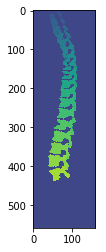

In [7]:
#plt.imshow(x[:,:,100], cmap='gray')#85-100
plt.imshow(x[:,:,100])#85-100

In [47]:
y_img, y_spacing = load_y('./Jack/labeled/case10_label.mhd')
generate_y(y_img, y_spacing, 90, 19)# 0-19

[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


False

In [22]:
# generate x and y for yolo training

# load x and y
case = 10
x_path = './Jack/images/case' + str(case) + '.mhd'
y_path = './Jack/labeled/case' + str(case) + '_label.mhd'
x = load_x(x_path)
y_img, y_spacing = load_y(y_path)

(552, 160, 160)


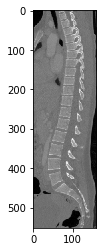

In [236]:
plt.imshow(x[:,:,80], cmap='gray')#85-100
#case, range
#1, 85-100
#2, 75-85
#3, 70-80
#4, 85-100
#5, 80-90
#6, 75-95
#7, none
#8, 80-85
#9, 80-90
#10, 65-80

In [23]:
# generate images and labels files for yolo training

for z in range(65,81):
    label_cnt = 1 # count of label occur
    y_lst = []
    for label in range(1, 20):# 1-19, 0 is background
        y = generate_y(y_img, y_spacing, z, label)
        if y != False:
            y = [str(label)] + y
            y_lst.append(y)
            label_cnt += 1
    
    print(z)
    if label_cnt > 15:
        print('output')
        file_name = str(case)+ '_' + str(z)

        # save x
        #plt.imshow(x[:,:,z], cmap='gray')
        cv2.imwrite('./yolo_data/images/case' + file_name + '.jpg', x[:,:,z])

        # save y
        line_lst = []
        for y in y_lst:
            line_lst.append(' '.join((y)))
        with open('./yolo_data/labels/case' + file_name + '.txt', "w") as f:
            f.writelines('\n'.join(line_lst))
    


65
output
66
output
67
output
68
output
69
output
70
output
71
output
72
output
73
output
74
output
75
output
76
output
77
output
78
output
79
output
80
output


In [26]:
# generate file list

import glob, os

# Current directory
current_dir = './yolo_data/images/'

# Directory where the data will reside, relative to 'darknet.exe'
path_data = 'data/ian/'

# Percentage of images to be used for the test set
percentage_test = 10;

# Create and/or truncate train.txt and test.txt
file_train = open('./yolo_data/train.txt', 'w')  
file_test = open('./yolo_data/test.txt', 'w')

# Populate train.txt and test.txt
counter = 1  
index_test = round(100 / percentage_test)  
for pathAndFilename in glob.iglob(os.path.join(current_dir, "*.jpg")):  
    print(pathAndFilename)
    title, ext = os.path.splitext(os.path.basename(pathAndFilename))

    if counter == index_test:
        counter = 1
        file_test.write(path_data + title + '.jpg' + "\n")
    else:
        file_train.write(path_data + title + '.jpg' + "\n")
        counter = counter + 1

./yolo_data/images/case10_65.jpg
./yolo_data/images/case10_66.jpg
./yolo_data/images/case10_67.jpg
./yolo_data/images/case10_68.jpg
./yolo_data/images/case10_69.jpg
./yolo_data/images/case10_70.jpg
./yolo_data/images/case10_71.jpg
./yolo_data/images/case10_72.jpg
./yolo_data/images/case10_73.jpg
./yolo_data/images/case10_74.jpg
./yolo_data/images/case10_75.jpg
./yolo_data/images/case10_76.jpg
./yolo_data/images/case10_77.jpg
./yolo_data/images/case10_78.jpg
./yolo_data/images/case10_79.jpg
./yolo_data/images/case10_80.jpg
./yolo_data/images/case1_100.jpg
./yolo_data/images/case1_85.jpg
./yolo_data/images/case1_86.jpg
./yolo_data/images/case1_87.jpg
./yolo_data/images/case1_88.jpg
./yolo_data/images/case1_89.jpg
./yolo_data/images/case1_90.jpg
./yolo_data/images/case1_91.jpg
./yolo_data/images/case1_92.jpg
./yolo_data/images/case1_93.jpg
./yolo_data/images/case1_94.jpg
./yolo_data/images/case1_95.jpg
./yolo_data/images/case1_96.jpg
./yolo_data/images/case1_97.jpg
./yolo_data/images/case